In [1]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time
import timeit
import h5py
import shutil
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.mixture import GaussianMixture
from sklearn import datasets, mixture

from math import ceil
from tqdm import tqdm
from collections import defaultdict
from IPython import display
from itertools import cycle, islice

import sys
sys.path.append('../../')

from evaluation import *
np.random.seed(10)
%matplotlib inline

/opt/conda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Сохранение/загрузка метрик

Сохраняет словарь с метриками в указанную папку с данным именем

In [2]:
def dump(saved_dict, folder, name):
    dict_for_json = {k: {kk: list(vv) for kk, vv in v.items()} if isinstance(v, dict) else list(v) 
                     for k, v in saved_dict.items()}
    with open(os.path.join(folder, name + ".json"), 'w', encoding="utf-8") as file:
        # writing
        json.dump(dict_for_json, file, indent=4, ensure_ascii=False)
    del dict_for_json

Метрики в указанной папке сохраняю в нумерованую папку(чтобы чаще дампить и удалять старые метрики + не запариваться о названиях)

Для этого первая функция возвращает последний номер из созданых папок

Вторая создает папку со следующим номером и возвращает названия новой и старой папки

In [3]:
def get_last_dir_n(metrics_path):
    try:
        last_folder_n = max(list(map(lambda name: int(name), 
                                     filter(lambda name: os.path.isdir(os.path.join(metrics_path, name)) 
                                            and name.isdecimal(), os.listdir(metrics_path)))))
    except:
        last_folder_n = 0
    return last_folder_n

def create_metrics_folder(metrics_path):
    last_folder_n = get_last_dir_n(metrics_path)
    new_folder = os.path.join(metrics_path, str(last_folder_n + 1))
    old_folder = os.path.join(metrics_path, str(last_folder_n))
    os.makedirs(new_folder)    
    return new_folder, old_folder

Костыльное сохранение метрик для supervised алгоритмов и удаление старой папки

In [4]:
def dump_metrics_sup(metrics_path):
    folder, old_folder = create_metrics_folder(metrics_path)
    print(folder)

    dump(supervised_pr_aucs, folder, "supervised_pr_aucs")
    dump(supervised_roc_aucs, folder, "supervised_roc_aucs")
    dump(supervised_p_at_10, folder, "supervised_p_at_10")
    dump(supervised_p_at_r, folder, "supervised_p_at_r")
    
    shutil.rmtree(old_folder, ignore_errors=True)
    

Загрузка метрик из указанной папки

In [5]:
def load_metrics(metrics_path):
    """
    Return
    ------
    metrics: dict, {metric_name: {clf_name: [(frac, metric_value), ...], ...}}
        frac == fraction of negative data used
    """
    metrics = {}
    folder = os.path.join(metrics_path, str(get_last_dir_n(metrics_path)))
    for file_name in filter(lambda name: name.endswith('.json'), os.listdir(folder)):
        with open(os.path.join(folder, file_name), 'r') as file:
            metrics[file_name[:-5]] = json.load(file)
    return metrics

## Построение графика

График зависимости значения метрики от доли используемых аномалий от имеющихся(1 == используем все имеющиеся аномалии)

In [6]:
def metric_boxplot(metrics, ylabel='PR_AUC', ylim=None):
    """
    Params
    ------
    metrics: dict, {clf_name: [(frac, metric_value), ...]}
        frac == fraction of negative data used
        all metric_values for one metric
    ylabel: str, name of current metric
    ylim: None or tuple, shape=(2)
        Parametr for Oy axis(metric value)
    """
    n = len(metrics.keys())
    plt.figure(figsize=(15, 7 * ceil(n/2)))

    for i, clf_name in enumerate(metrics.keys()):
        plt.subplot(ceil(n/2), 2, i + 1)
        sns.boxplot(np.array(metrics[clf_name])[:, 0]*100, np.array(metrics[clf_name])[:, 1])
        plt.ylim(ylim)
        plt.xlabel("% of used anomalies")
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.title(clf_name)

## Supervised(XGB с оптимальными параметрами)

Костыльная загрузка метрик для supervised алгоритмов

In [7]:
def init_supervised(metrics_path):
    metrics = load_metrics(metrics_path)
    supervised_pr_aucs = metrics['supervised_pr_aucs']
    supervised_roc_aucs = metrics['supervised_roc_aucs']
#     supervised_p_at_10 = metrics['supervised_p_at_10']
    supervised_p_at_r = metrics['supervised_p_at_r']
    return supervised_pr_aucs, supervised_roc_aucs, supervised_p_at_r

In [8]:
metrics_path = './metrics/xgb_opt'
# supervised_pr_aucs, supervised_roc_aucs, supervised_p_at_10, supervised_p_at_r = init_supervised(metrics_path)
supervised_pr_aucs, supervised_roc_aucs, supervised_p_at_r = init_supervised(metrics_path)

#### Построим графики

Делал несколько перезапусков обучения, изменяя используемые негативные примеры

In [9]:
fraction_of_negative_used = np.array([0.001, 0.01, 0.1, 0.5, 1, 5, 10, 25, 100]) / 100.
n_resplits = np.array([20, 20, 20, 20, 4, 4, 4, 4, 4])
print(*map(lambda pair: "{} раз перезапускал обучение при доли негативного класса: {}".format(*pair), 
          zip(n_resplits, fraction_of_negative_used)), sep='\n')

20 раз перезапускал обучение при доли негативного класса: 1e-05
20 раз перезапускал обучение при доли негативного класса: 0.0001
20 раз перезапускал обучение при доли негативного класса: 0.001
20 раз перезапускал обучение при доли негативного класса: 0.005
4 раз перезапускал обучение при доли негативного класса: 0.01
4 раз перезапускал обучение при доли негативного класса: 0.05
4 раз перезапускал обучение при доли негативного класса: 0.1
4 раз перезапускал обучение при доли негативного класса: 0.25
4 раз перезапускал обучение при доли негативного класса: 1.0


PR AUC для XGBoostClassifier при n_estimators = [60, 200, 500, 1000, 1500]

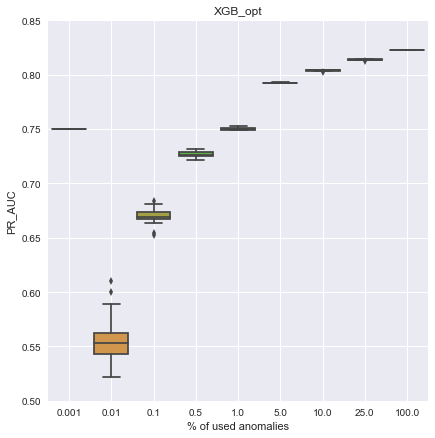

In [11]:
metric_boxplot(supervised_pr_aucs, ylabel='PR_AUC', ylim=(0.5, 0.85))

ROC AUC для XGBoostClassifier при n_estimators = [60, 200, 500, 1000, 1500]

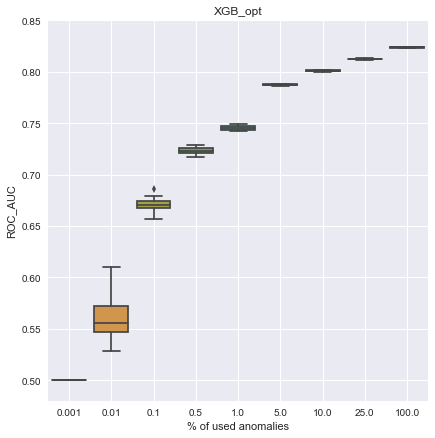

In [15]:
metric_boxplot(supervised_roc_aucs, ylabel='ROC_AUC', ylim=(0.48, 0.85))

P@R:[0.8, 0.9, 0.95, 0.99] для XGBoostClassifier при n_estimators = [60, 200, 500, 1000, 1500]

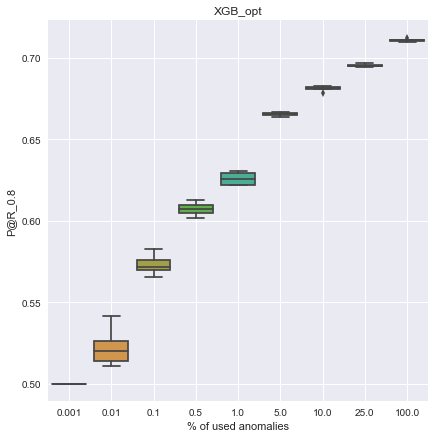

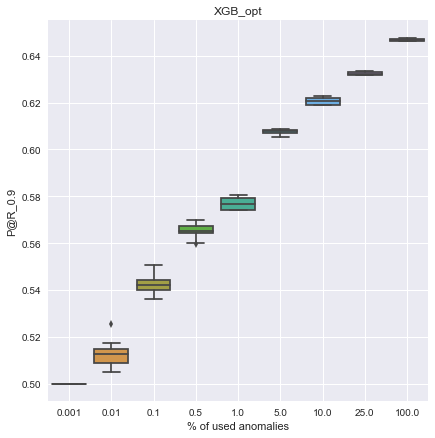

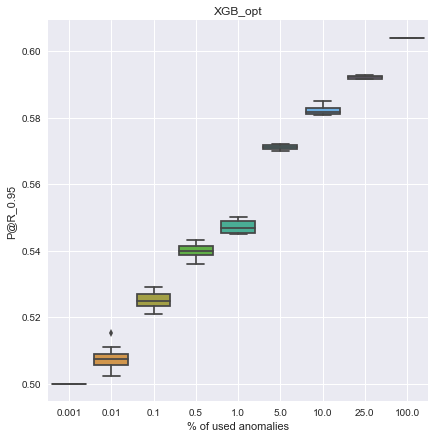

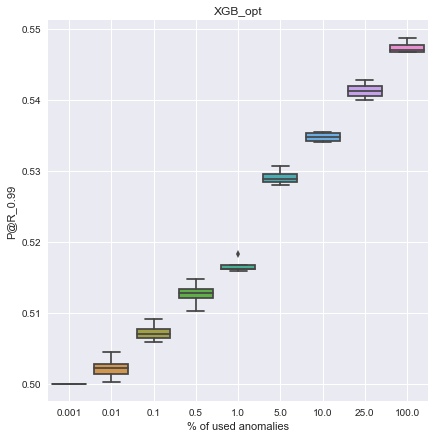

In [14]:
for k in supervised_p_at_r.keys():
    metric_boxplot(supervised_p_at_r[k], ylabel='P@R_' + str(k))
    plt.show()

## Unsupervised

Костыльная загрузка метрик для unsupervised алгоритмов

In [13]:
def init_unsupervised(metrics_path):
    metrics = load_metrics(metrics_path)
    unsupervised_pr_aucs = metrics['unsupervised_pr_aucs']
    unsupervised_roc_aucs = metrics['unsupervised_roc_aucs']
#     unsupervised_p_at_n = metrics['unsupervised_p_at_n']
    unsupervised_p_at_r = metrics['unsupervised_p_at_r']
    return unsupervised_pr_aucs, unsupervised_roc_aucs, unsupervised_p_at_r

In [14]:
metrics_path = './metrics/unsupervised/SVM_opt/'
# unsupervised_pr_aucs, unsupervised_roc_aucs, unsupervised_p_at_n, unsupervised_p_at_r = init_unsupervised(metrics_path)
unsupervised_pr_aucs, unsupervised_roc_aucs, unsupervised_p_at_r = init_unsupervised(metrics_path)

In [15]:
metrics_path = './metrics/unsupervised/IF_opt/'
# unsupervised_pr_aucs, unsupervised_roc_aucs, unsupervised_p_at_n, unsupervised_p_at_r = init_unsupervised(metrics_path)
IF_pr_aucs, IF_roc_aucs, IF_p_at_r = init_unsupervised(metrics_path)

In [16]:
unsupervised_pr_aucs.update(IF_pr_aucs)
unsupervised_roc_aucs.update(IF_roc_aucs)
for k in unsupervised_p_at_r.keys():
    unsupervised_p_at_r[k].update(IF_p_at_r[k])

#### Построим графики

PR AUC для One-Class SVM и Isolation Forest

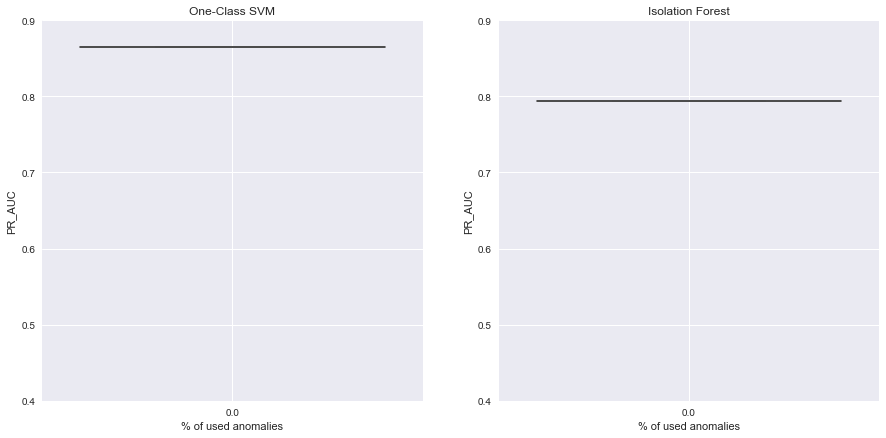

In [17]:
metric_boxplot(unsupervised_pr_aucs, ylabel='PR_AUC', ylim=(0.4, 0.9))

ROC AUC для One-Class SVM и Isolation Forest

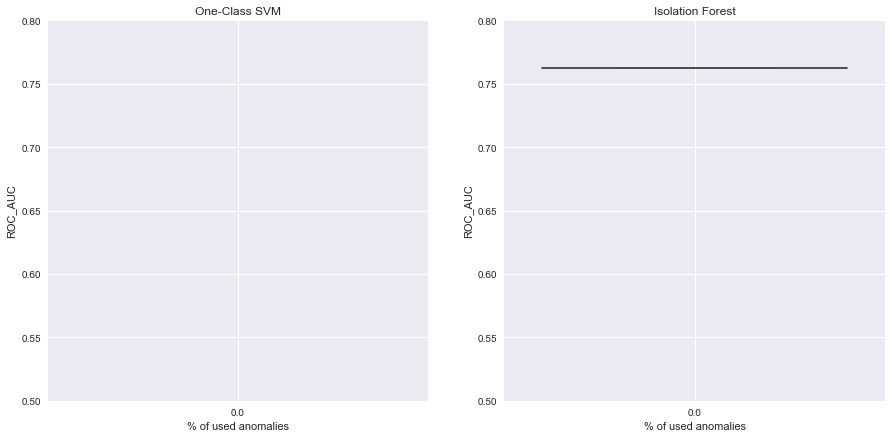

In [18]:
metric_boxplot(unsupervised_roc_aucs, ylabel='ROC_AUC', ylim=(0.5, 0.8))

P@R:[0.8, 0.9, 0.95, 0.99] для One-Class SVM и Isolation Forest

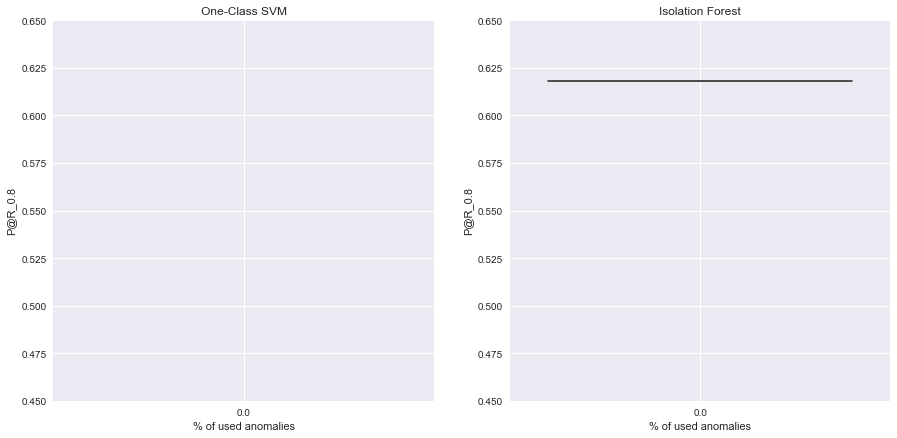

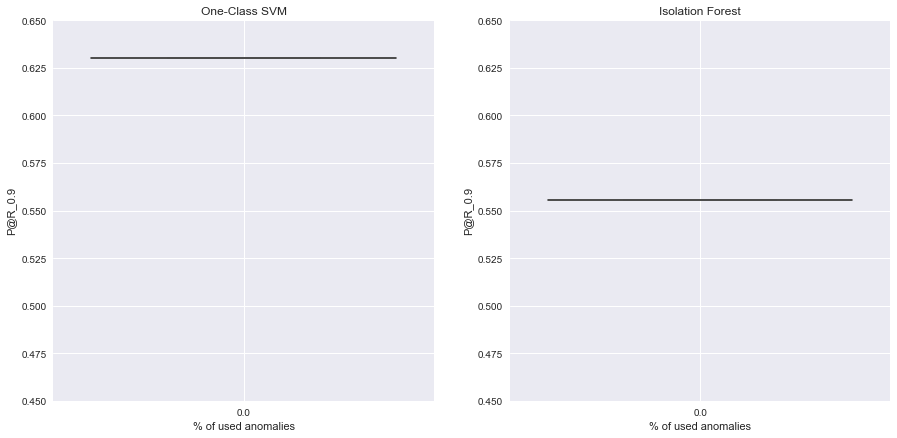

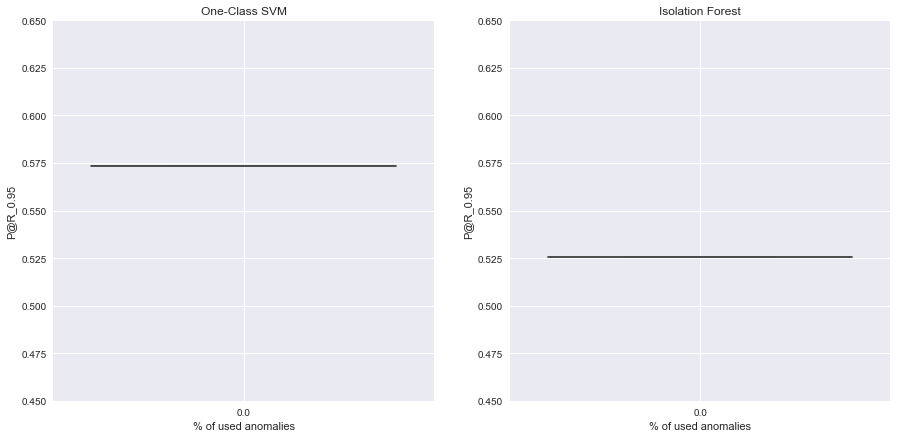

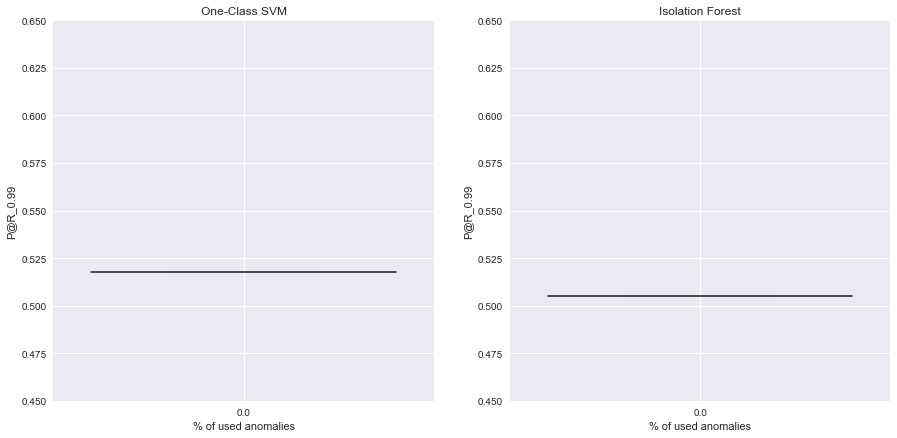

In [19]:
for k in unsupervised_p_at_r.keys():
    metric_boxplot(unsupervised_p_at_r[k], ylabel='P@R_' + str(k), ylim=(0.45, 0.65))
    plt.show()

# (1 + e) алгоритм

Костыльная загрузка метрик для (1 + e) алгоритмов(разные alpha, разные алгоритмы)

<a href="https://3.basecamp.com/3895643/buckets/5714528/messages/993962676">Про разные alpha</a>

In [16]:
def init_ours(metrics_path):
    metrics = load_metrics(metrics_path)
    ours_pr_aucs = metrics['ours_pr_aucs']
    ours_roc_aucs = metrics['ours_roc_aucs']
    ours_p_at_r = metrics['ours_p_at_r']
    return ours_pr_aucs, ours_roc_aucs, ours_p_at_n, ours_p_at_r

Склеим разные alpha

In [17]:
alphas = list(map(str, [0, 0.1, 0.25, 0.5 ,1]))

In [18]:
metrics_path = './metrics/our/alpha_'
ours_pr_aucs, ours_roc_aucs, ours_p_at_n, ours_p_at_r = {}, {}, defaultdict(dict), defaultdict(dict)
for alpha in alphas:
    cur_ours_pr_aucs, cur_ours_roc_aucs, cur_ours_p_at_n, cur_ours_p_at_r = init_ours(metrics_path + alpha)
    ours_pr_aucs[alpha] = cur_ours_pr_aucs[alpha]
    ours_roc_aucs[alpha] = cur_ours_roc_aucs[alpha]
    for k in cur_ours_p_at_n.keys():
        ours_p_at_n[k][alpha] = cur_ours_p_at_n[k][alpha]
    for k in cur_ours_p_at_r.keys():
        ours_p_at_r[k][alpha] = cur_ours_p_at_r[k][alpha]

In [19]:
ours_pr_aucs.keys()

dict_keys(['0', '0.1', '0.25', '0.5', '1'])

#### Построим графики

Делал несколько перезапусков обучения, изменяя используемые негативные примеры

In [20]:
fraction_of_negative_used = np.array([0.001, 0.01, 0.1, 0.5, 1, 5, 10, 25, 100]) / 100.
n_resplits = np.array([20, 20, 20, 20, 4, 4, 4, 4, 4])
print(*map(lambda pair: "{} раз перезапускал обучение при доли негативного класса: {}".format(*pair), 
          zip(n_resplits, fraction_of_negative_used)), sep='\n')

20 раз перезапускал обучение при доли негативного класса: 1e-05
20 раз перезапускал обучение при доли негативного класса: 0.0001
20 раз перезапускал обучение при доли негативного класса: 0.001
20 раз перезапускал обучение при доли негативного класса: 0.005
4 раз перезапускал обучение при доли негативного класса: 0.01
4 раз перезапускал обучение при доли негативного класса: 0.05
4 раз перезапускал обучение при доли негативного класса: 0.1
4 раз перезапускал обучение при доли негативного класса: 0.25
4 раз перезапускал обучение при доли негативного класса: 1.0


#### title == alpha value

In [21]:
len(ours_pr_aucs['0.25'])

50

In [22]:
len(ours_pr_aucs['0.5'])

51

In [23]:
len(ours_pr_aucs['0'])

48

In [24]:
len(ours_pr_aucs['1'])

50

PR AUC для (1 + e)

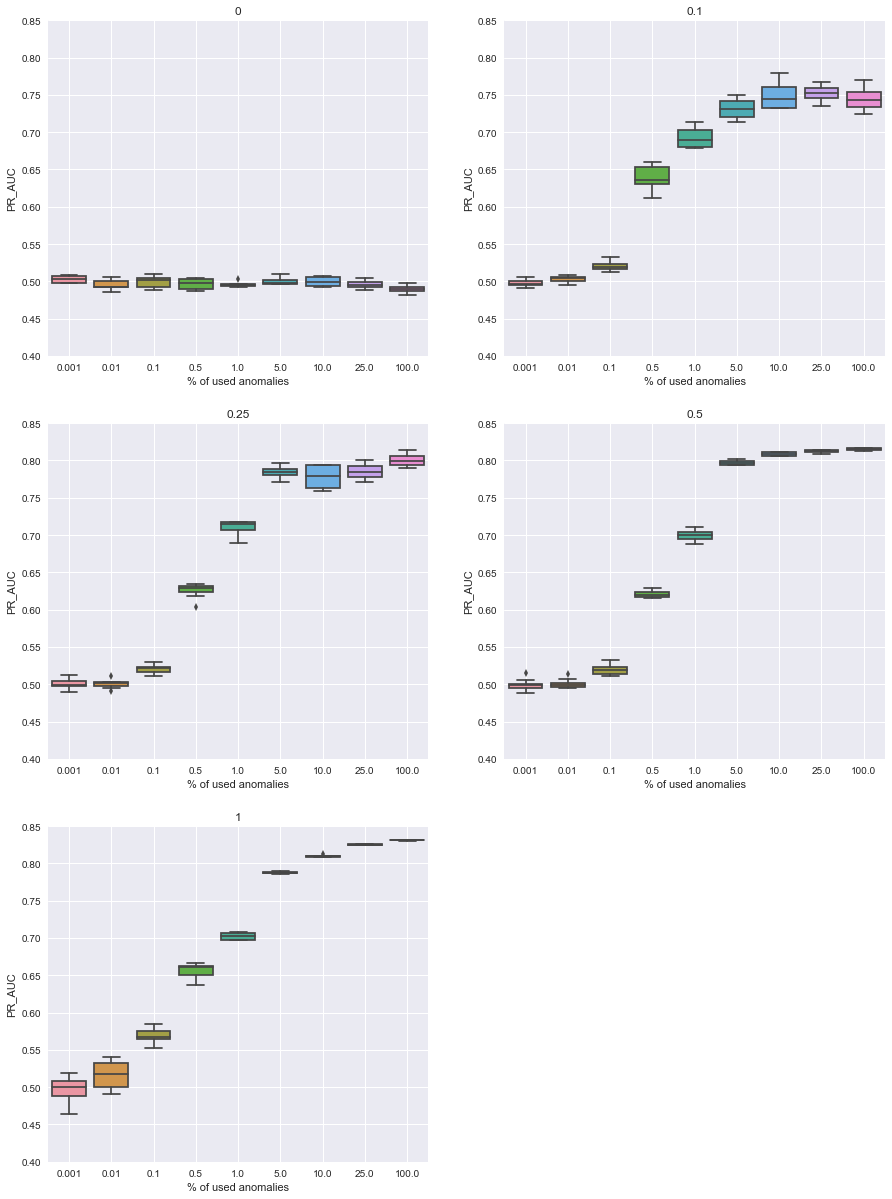

In [26]:
metric_boxplot(ours_pr_aucs, ylabel='PR_AUC', ylim=(0.4, 0.85))

ROC AUC для (1 + e)

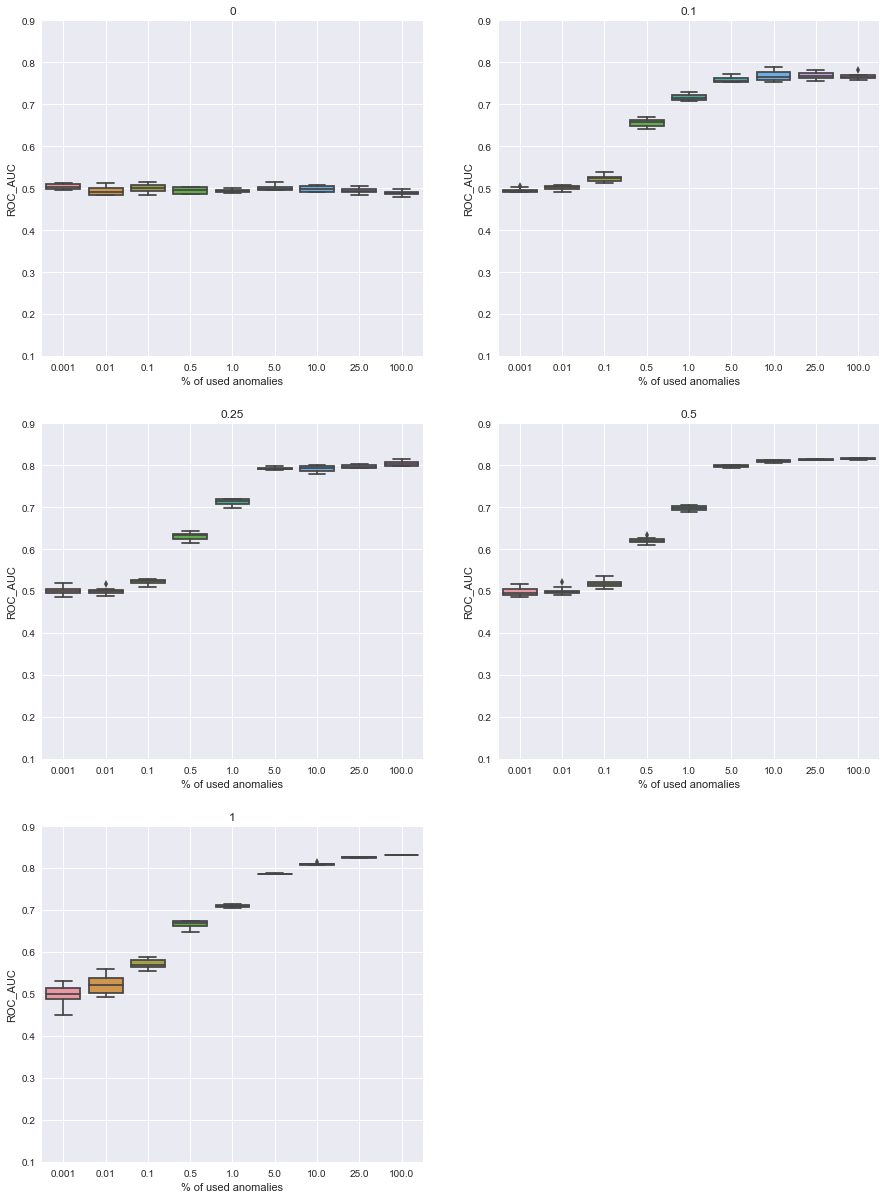

In [27]:
metric_boxplot(ours_roc_aucs, ylabel='ROC_AUC', ylim=(0.1, 0.9))

P@R:[0.8, 0.9, 0.95, 0.99] для (1 + e)

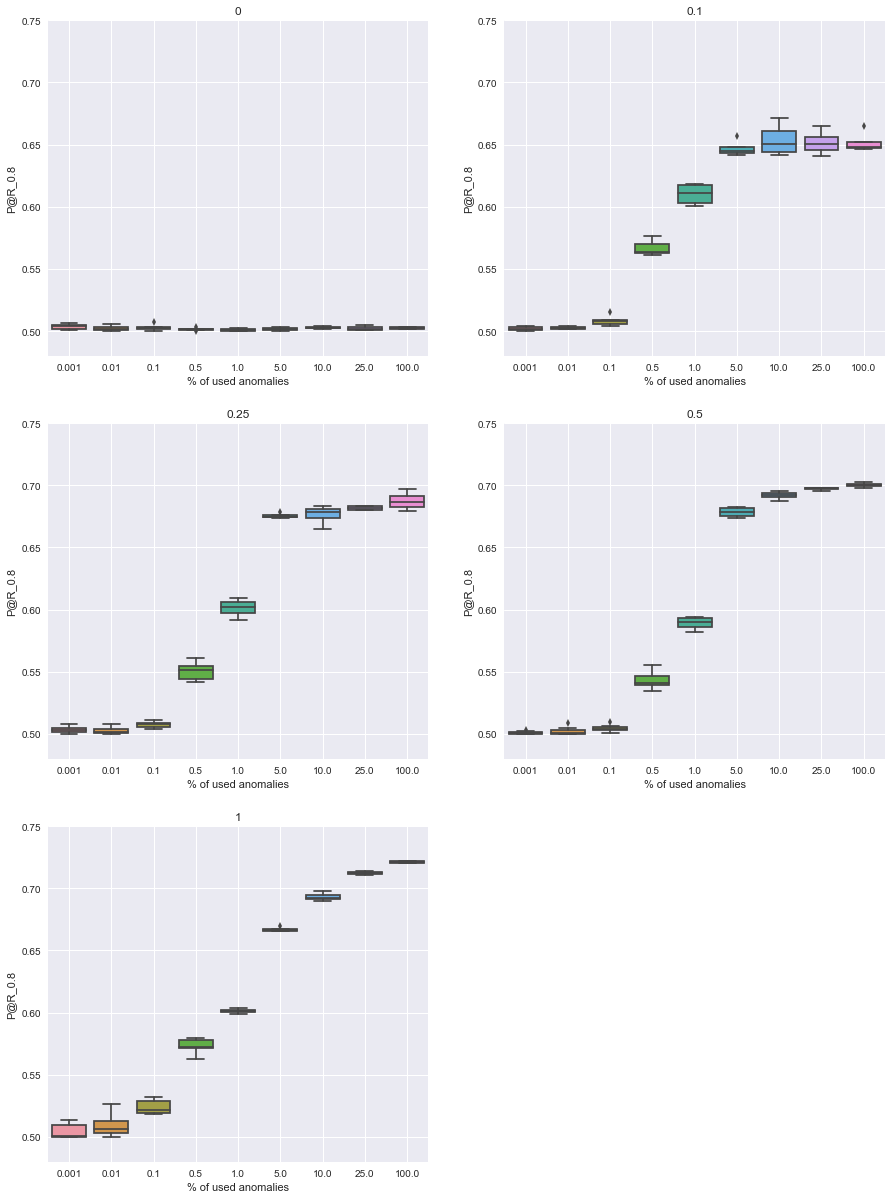

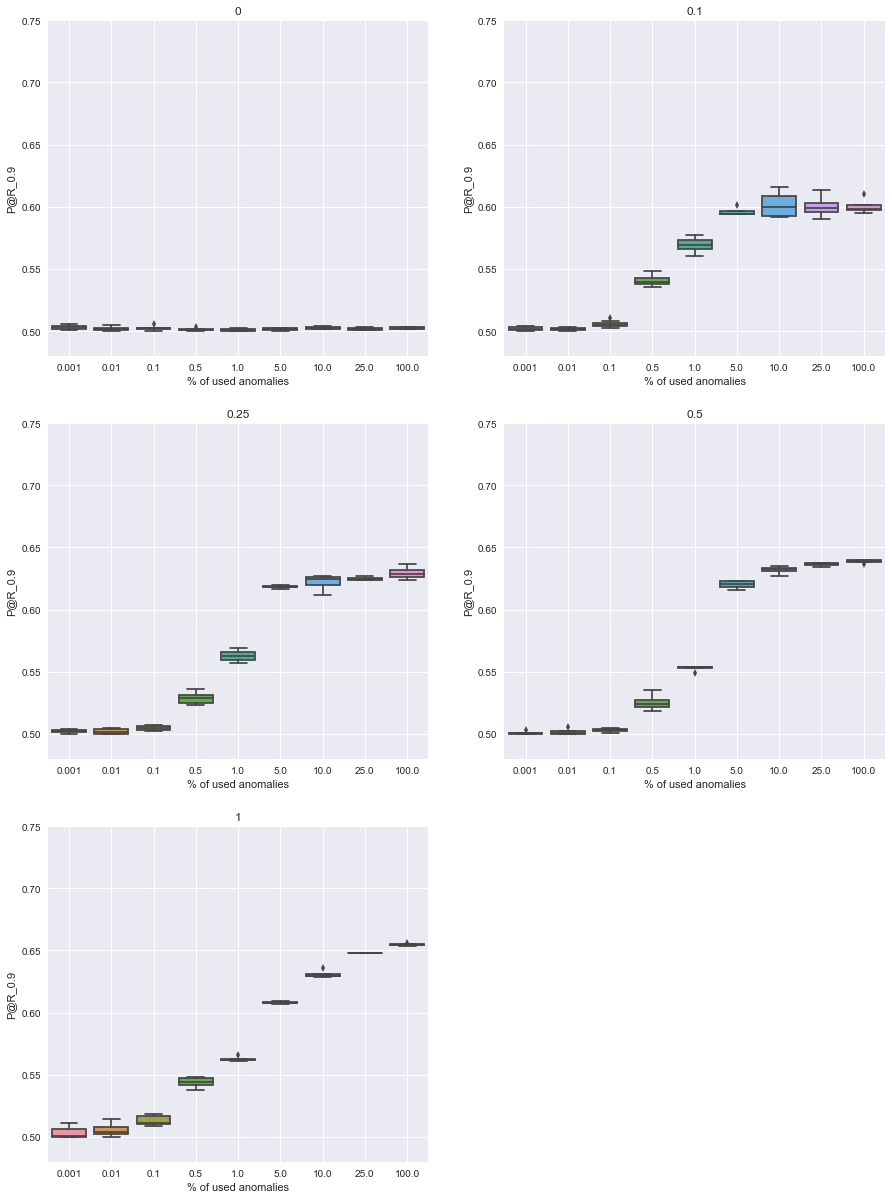

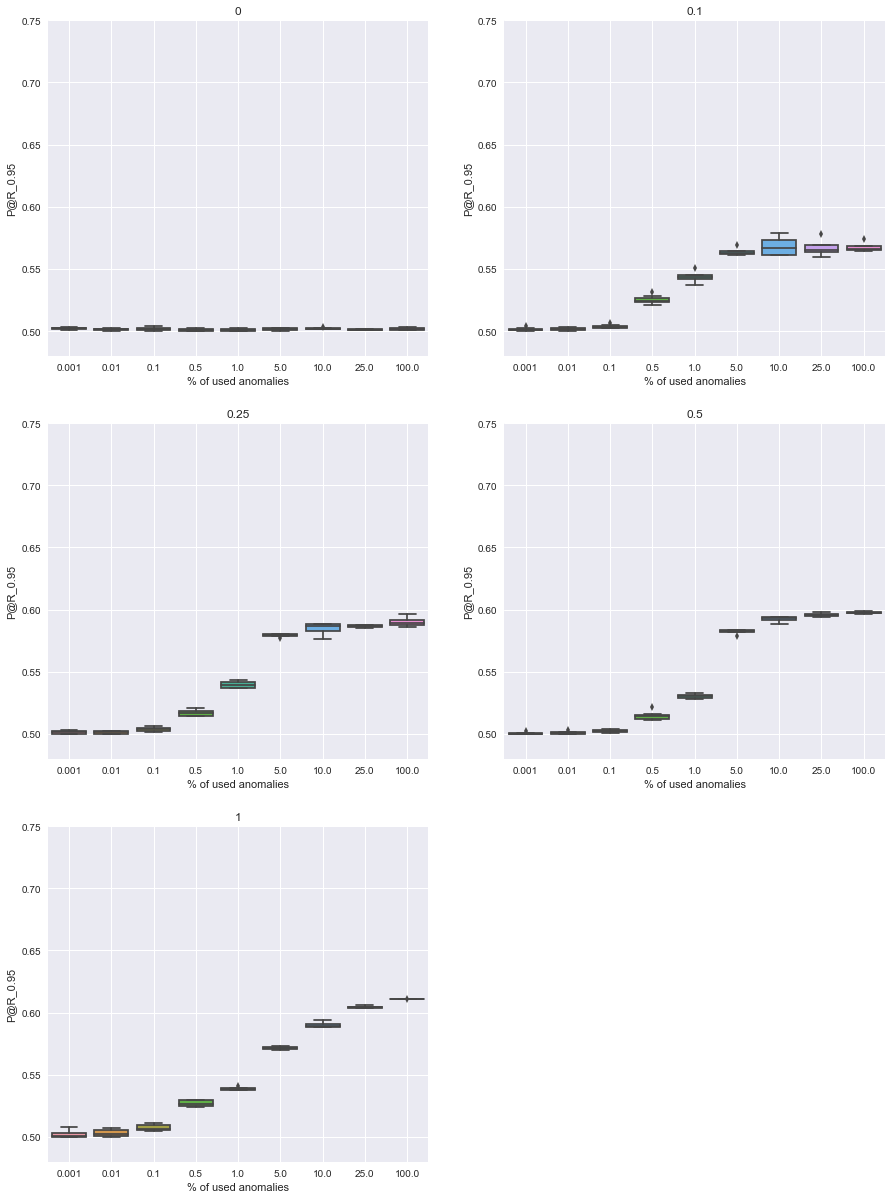

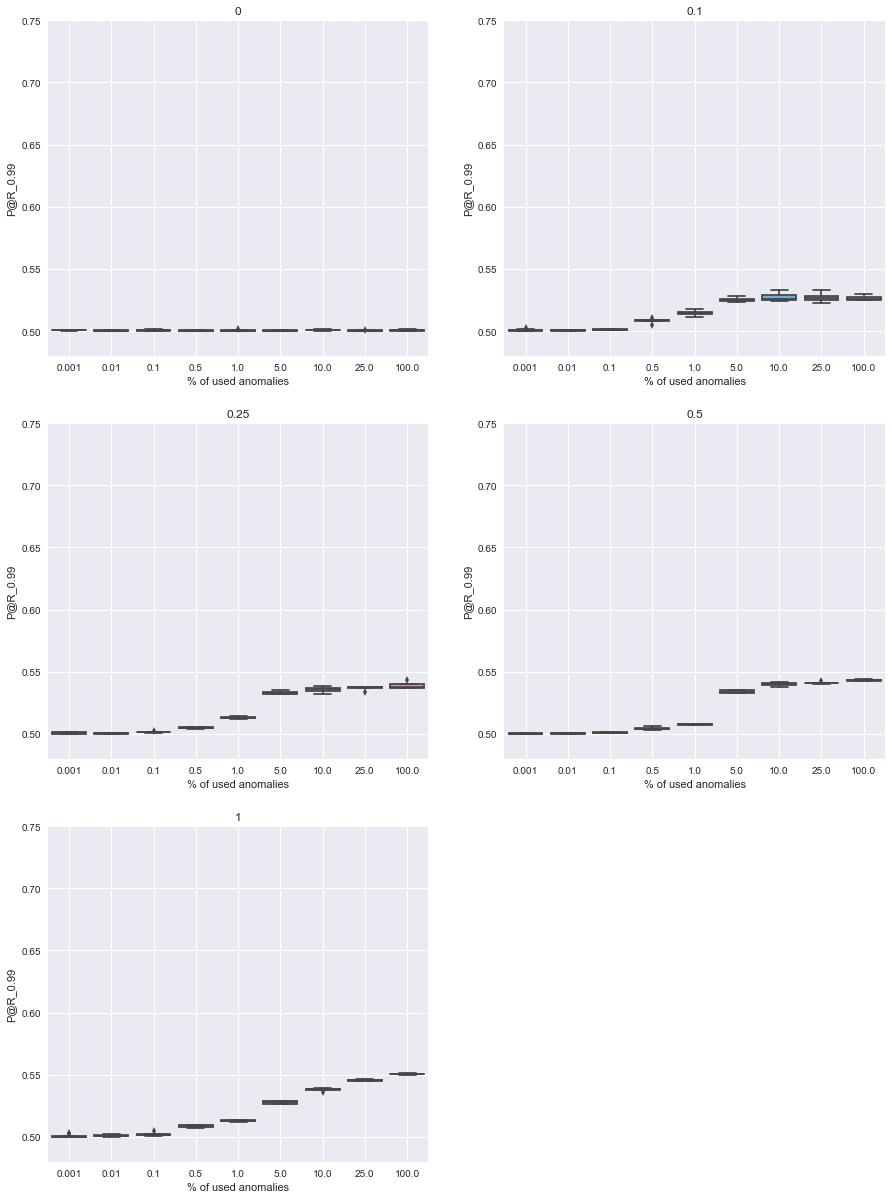

In [30]:
for k in ours_p_at_r.keys():
    metric_boxplot(ours_p_at_r[k], ylabel='P@R_' + str(k), ylim=(0.48, 0.75))
    plt.show()

## Построим все алгоритмы на одном графике

Усреднение значений метрики по долям используемых аномалий(нужно для supervised и ours)

In [31]:
def mean_metric(metric_arr):
    """
    Params
    ------
    metric_arr: list, shape=(n_metric_values, 2)
        format=[[frac, metric_value], ...]
        frac == fraction of negative data used
        
    Return
    ------
    metric_reduce: list, shape=(n_fractions, 2)
    """
    metric_map = defaultdict(list)
    for x, y in metric_arr:
        metric_map[x].append(y)
    metric_reduce = [[k, np.mean(v)] for k, v in metric_map.items()]
    metric_reduce.sort()
    return metric_reduce

In [32]:
mean_metric(supervised_pr_aucs['XGB_opt'])

[[1e-05, 0.75],
 [0.0001, 0.5562205587619443],
 [0.001, 0.6694643125848441],
 [0.005, 0.7266383141587005],
 [0.01, 0.750530931538318],
 [0.05, 0.7923953571067863],
 [0.1, 0.8036405055235023],
 [0.25, 0.8136336413719913],
 [1.0, 0.8226846237253879]]

Дублируем значения метрик на все доли используемых аномалий(нужно для unsupervised)

In [33]:
def dublicate_metric(metric_arr, fraction_of_negative_used):
    """
    Params
    ------
    metric_arr: list, shape=(1, 2)
        format=[[frac, metric_value]]
        frac == fraction of negative data used
    """
    return [[frac, metric_arr[0][1]] for frac in fraction_of_negative_used]

In [34]:
fraction_of_negative_used = np.array([0.001, 0.01, 0.1, 0.5, 1, 5, 10, 25, 100]) / 100.

In [36]:
unsupervised_pr_aucs['Isolation Forest']

[[0, 0.7940936375616696]]

In [37]:
dublicate_metric(unsupervised_pr_aucs['Isolation Forest'], fraction_of_negative_used)

[[1e-05, 0.7940936375616696],
 [0.0001, 0.7940936375616696],
 [0.001, 0.7940936375616696],
 [0.005, 0.7940936375616696],
 [0.01, 0.7940936375616696],
 [0.05, 0.7940936375616696],
 [0.1, 0.7940936375616696],
 [0.25, 0.7940936375616696],
 [1.0, 0.7940936375616696]]

Теперь выравняем измерения для различных алгоритмов по значениям fraction_of_negative_used

all_methods = list(ours_pr_aucs.keys()) + list(supervised_roc_aucs.keys())

In [38]:
all_methods = list(unsupervised_pr_aucs.keys()) + list(ours_pr_aucs.keys()) + list(supervised_roc_aucs.keys())

In [36]:
all_methods

['0', '0.1', '0.25', '0.5', '1', 'XGB_opt']

In [37]:
ours_pr_aucs.keys()

dict_keys(['0', '0.1', '0.25', '0.5', '1'])

Из словарей {классификатор: метрика} делает один для всех классификаторов с выровненными по размеру значениями

In [38]:
def create_metrics_dict_by_clf(unsupervised, supervised, ours, fraction_of_negative_used):
    """
    Params
    ------
    unsupervised: dict, {clf_name: [[frac, metric_value]]}
        unsupervised[clf_name].shape == (1, 2)
        
    supervised: dict, {clf_name: [[frac, metric_value], ...]}
        supervised[clf_name].shape == (n_metric_values, 2)
        
    ours: dict, {clf_name: [[frac, metric_value], ...]}
        ours[clf_name].shape == (n_metric_values, 2)
    
    Return
    ------
    metrics_dict: dict, {clf_name: [[frac, metric_value], ...]}
        metrics_dict[clf_name].shape == (len(fraction_of_negative_used), 2)
    """
    metrics_dict = {k: dublicate_metric(v, fraction_of_negative_used) for k, v in unsupervised.items()}
    metrics_dict.update({k: mean_metric(v) for k, v in supervised.items()})
    metrics_dict.update({k: mean_metric(v) for k, v in ours.items()})
    return metrics_dict

unsupervised_pr_aucs = {}
unsupervised_roc_aucs = {}
unsupervised_p_at_r = {key : {} for key in ours_p_at_r.keys()}

In [40]:
pr_s = create_metrics_dict_by_clf(unsupervised_pr_aucs, supervised_pr_aucs, ours_pr_aucs, fraction_of_negative_used)

In [41]:
roc_s = create_metrics_dict_by_clf(unsupervised_roc_aucs, supervised_roc_aucs, ours_roc_aucs, fraction_of_negative_used)

In [42]:
p_at_r_s = {}
for key in ours_p_at_r.keys():
    p_at_r_s[key] = create_metrics_dict_by_clf(
        unsupervised_p_at_r[key], supervised_p_at_r[key], ours_p_at_r[key], fraction_of_negative_used)

##  Графики средних значений

In [43]:
from matplotlib.colors import LinearSegmentedColormap

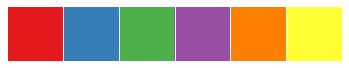

In [44]:
sns.palplot(sns.color_palette("Set1", len(all_methods[:9])))

In [45]:
cmap = sns.color_palette("Set1", len(all_methods[:9]))

In [46]:
def plot_for_comparison(metrics_dict, ylabel="PR AUC", y_lim=(0.3, 1.0), cmap=None):
    plt.style.use('seaborn-white')
    plt.figure(figsize=(16, 7))
    for i, name in enumerate(metrics_dict.keys()):
        x, y = list(map(list, zip(*metrics_dict[name])))
        if i == 0:
            x2tick = {x[j]: j/len(x) for j in range(len(x))}
            plt.xticks(np.arange(len(x))/len(x), np.array(x) * 100)
            
        ticks = [x2tick[xx] for xx in x]
        if cmap is not None:
            plt.plot(ticks, y, label=name, color=cmap[i%len(cmap)])
        else:
            plt.plot(ticks, y, label=name)
    
    plt.ylabel(ylabel)
    plt.ylim(y_lim)
    plt.xlabel("% of used anomalies")
    plt.xlim(0, 1)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

#### PR AUC

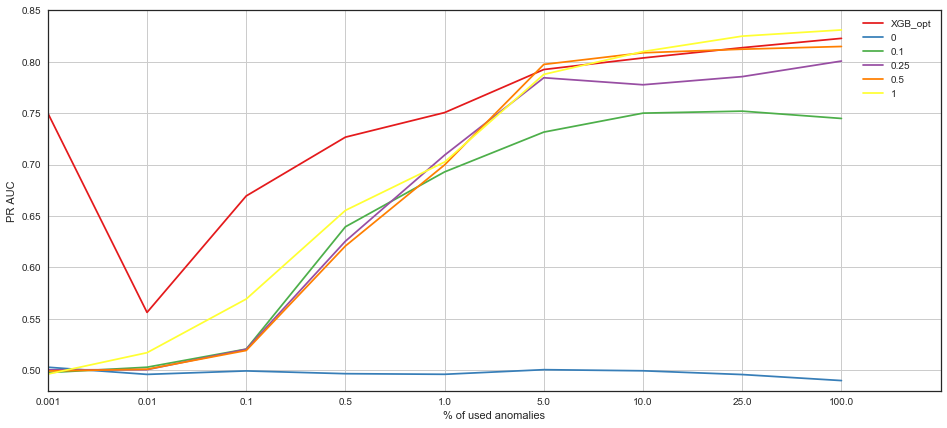

In [48]:
plot_for_comparison(pr_s, ylabel="PR AUC", y_lim=(0.48, 0.85), cmap=cmap)

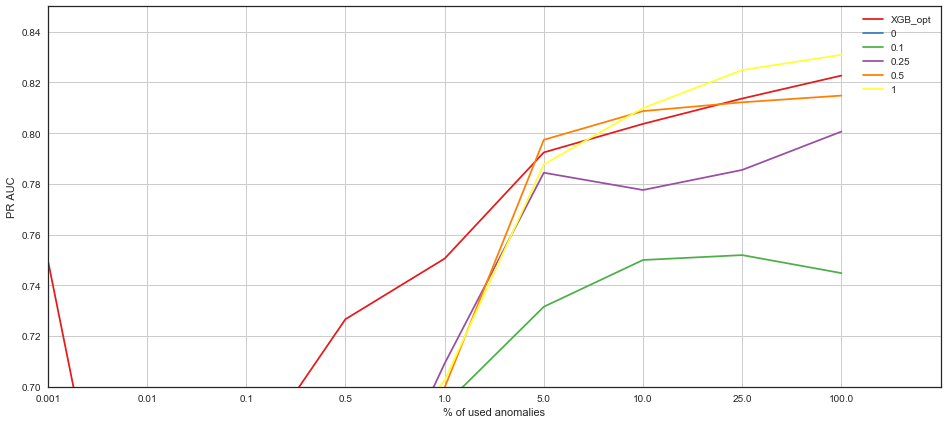

In [49]:
plot_for_comparison(pr_s, ylabel="PR AUC", y_lim=(0.7, 0.85), cmap=cmap)

#### ROC AUC

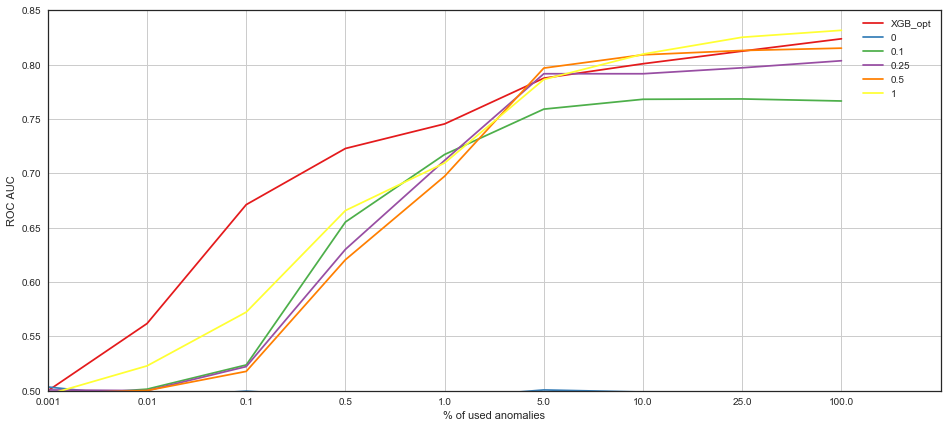

In [51]:
plot_for_comparison(roc_s, ylabel="ROC AUC", y_lim=(0.5, 0.85), cmap=cmap)

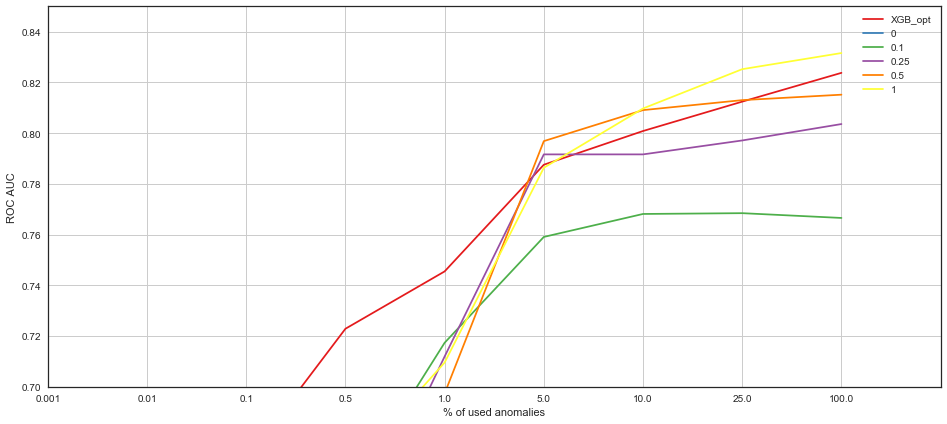

In [53]:
plot_for_comparison(roc_s, ylabel="ROC AUC", y_lim=(0.7, 0.85), cmap=cmap)

#### Precision at recall

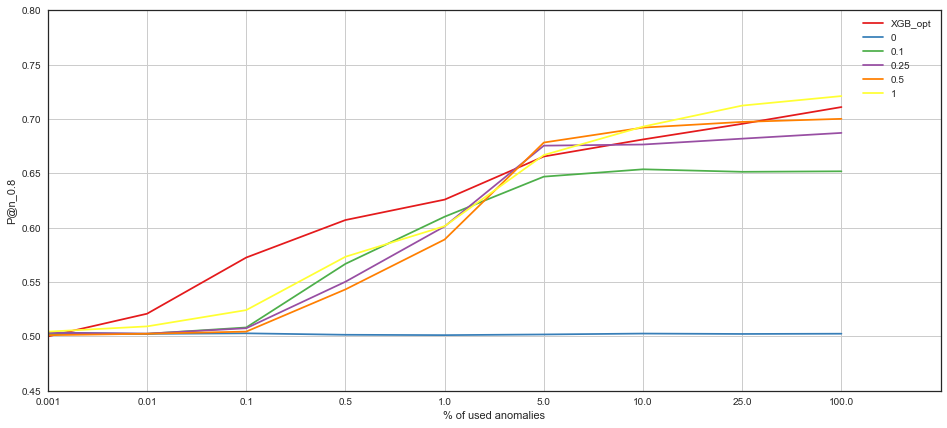

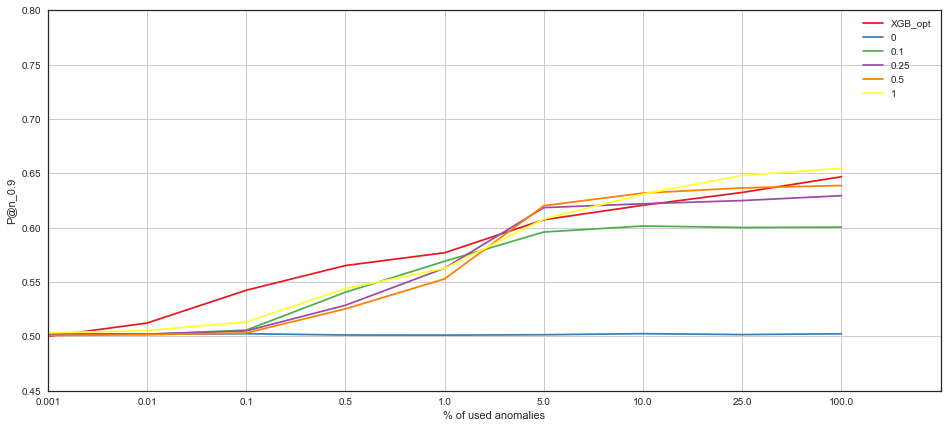

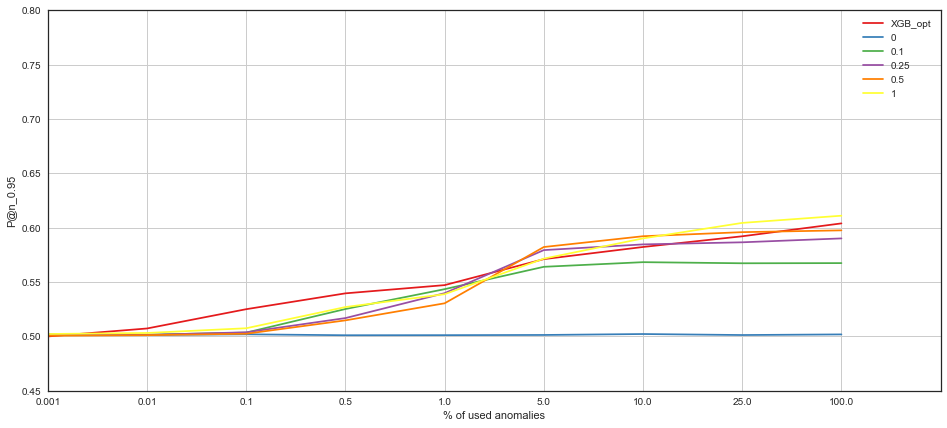

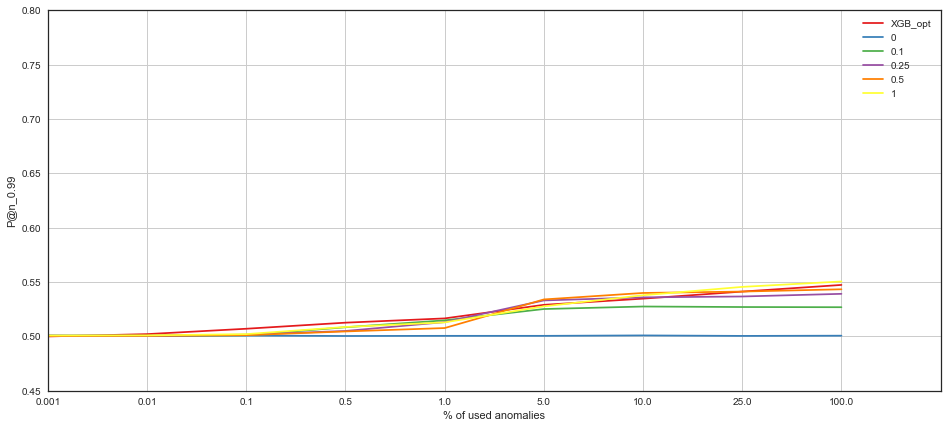

In [54]:
for key in p_at_r_s.keys():
    plot_for_comparison(p_at_r_s[key], ylabel="P@n_" + str(key), y_lim=(0.45, 0.8), cmap=cmap)

# Графики с погрешностями

In [55]:
lower_percentile = (100 - 68)/2
upper_percentile = 100 - (100 - 68)/2
print("Построим перцентили ", lower_percentile, ' и ', upper_percentile)

Построим перцентили  16.0  и  84.0


In [56]:
def get_percentiles(metric_arr, lower_percentile, upper_percentile):
    metric_map = defaultdict(list)
    for x, y in metric_arr:
        metric_map[x].append(y)
    metric_lower = [[k, np.percentile(v, lower_percentile)] for k, v in metric_map.items()]
    metric_upper = [[k, np.percentile(v, upper_percentile)] for k, v in metric_map.items()]
    metric_lower.sort()
    metric_upper.sort()
    return metric_lower, metric_upper

In [57]:
get_percentiles(supervised_pr_aucs['XGB_opt'], lower_percentile, upper_percentile)

([[1e-05, 0.75],
  [0.0001, 0.5310073673201835],
  [0.001, 0.66587358969406],
  [0.005, 0.7237886130897629],
  [0.01, 0.7493786197948076],
  [0.05, 0.7920013830128019],
  [0.1, 0.8032896596797505],
  [0.25, 0.8131414376369746],
  [1.0, 0.822345251407429]],
 [[1e-05, 0.75],
  [0.0001, 0.582523491165281],
  [0.001, 0.6745009579016842],
  [0.005, 0.7292275309085225],
  [0.01, 0.7517009029287851],
  [0.05, 0.7927938638720068],
  [0.1, 0.8039775723157799],
  [0.25, 0.8141161505550619],
  [1.0, 0.8230206242703295]])

Из словарей {классификатор: метрика} делает один для всех классификаторов с выровненными по размеру значениями

In [58]:
def create_metrics_dict_by_clf_with_percentile(unsupervised, supervised, ours, 
                                               fraction_of_negative_used, lower_percentile, upper_percentile):
    """
    Params
    ------
    unsupervised: dict, {clf_name: [[frac, metric_value]]}
        unsupervised[clf_name].shape == (1, 2)
        
    supervised: dict, {clf_name: [[frac, metric_value], ...]}
        supervised[clf_name].shape == (n_metric_values, 2)
        
    ours: dict, {clf_name: [[frac, metric_value], ...]}
        ours[clf_name].shape == (n_metric_values, 2)
    
    Return
    ------
    metrics_dict: dict, {clf_name: [[frac, metric_value], ...]}
        metrics_dict[clf_name].shape == (len(fraction_of_negative_used), 2)
    """
    metrics_dict = {k: [dublicate_metric(v, fraction_of_negative_used)] * 3 for k, v in unsupervised.items()}
    metrics_dict.update({k: [mean_metric(v), *get_percentiles(v, lower_percentile, upper_percentile)] 
                         for k, v in supervised.items()})
    metrics_dict.update({k: [mean_metric(v), *get_percentiles(v, lower_percentile, upper_percentile)] 
                         for k, v in ours.items()})
    return metrics_dict

In [59]:
pr_s_per = create_metrics_dict_by_clf_with_percentile(
    unsupervised_pr_aucs, supervised_pr_aucs, ours_pr_aucs, 
    fraction_of_negative_used, lower_percentile, upper_percentile)

In [60]:
roc_s_per = create_metrics_dict_by_clf_with_percentile(
    unsupervised_roc_aucs, supervised_roc_aucs, ours_roc_aucs,
    fraction_of_negative_used, lower_percentile, upper_percentile)

In [61]:
p_at_r_s_per = {}
for key in ours_p_at_r.keys():
    p_at_r_s_per[key] = create_metrics_dict_by_clf_with_percentile(
        unsupervised_p_at_r[key], supervised_p_at_r[key], ours_p_at_r[key],
        fraction_of_negative_used, lower_percentile, upper_percentile)

Построение графиков с заливкой

In [62]:
def plot_for_comparison_with_percentile(metrics_dict, ylabel="PR AUC", y_lim=(0.3, 1.0), 
                                        cmap=None, clf_names=None, alpha=0.2):
    plt.style.use('seaborn-white')
    plt.figure(figsize=(16, 7))
    is_first_clf = True
    for i, name in enumerate(metrics_dict.keys()):
        if name not in clf_names:
            continue
        x, y = list(map(list, zip(*metrics_dict[name][0])))
        if is_first_clf:
            x2tick = {x[j]: j/len(x) for j in range(len(x))}
            plt.xticks(np.arange(len(x))/len(x), np.array(x) * 100)
            is_first_clf = False
        
        ticks = [x2tick[xx] for xx in x]
        _, y_lower = list(map(list, zip(*metrics_dict[name][1])))
        _, y_upper = list(map(list, zip(*metrics_dict[name][2])))
        if cmap is not None:
            plt.plot(ticks, y, label=name, color=cmap[i%len(cmap)])
            plt.fill_between(ticks, y_lower, y_upper, color=cmap[i%len(cmap)], alpha=alpha)
        else:
            plt.plot(ticks, y, label=name)
            plt.fill_between(ticks, y_lower, y_upper, color=cmap[i%len(cmap)], alpha=alpha)
    
    plt.ylabel(ylabel)
    plt.ylim(y_lim)
    plt.xlabel("% of used anomalies")
    plt.xlim(0, 1)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [63]:
lower_percentile = (100 - 68)/2
upper_percentile = 100 - (100 - 68)/2
print("Построим перцентили ", lower_percentile, ' и ', upper_percentile)

Построим перцентили  16.0  и  84.0


### Построим графики для всех алгоритмов

In [64]:
clf_names = [
#     'One-Class SVM', 'Isolation Forest', 
    'XGB_opt',
    '0', 
    '0.1', 
    '0.25', 
    '0.5', 
    '1',
]

#### PR AUC

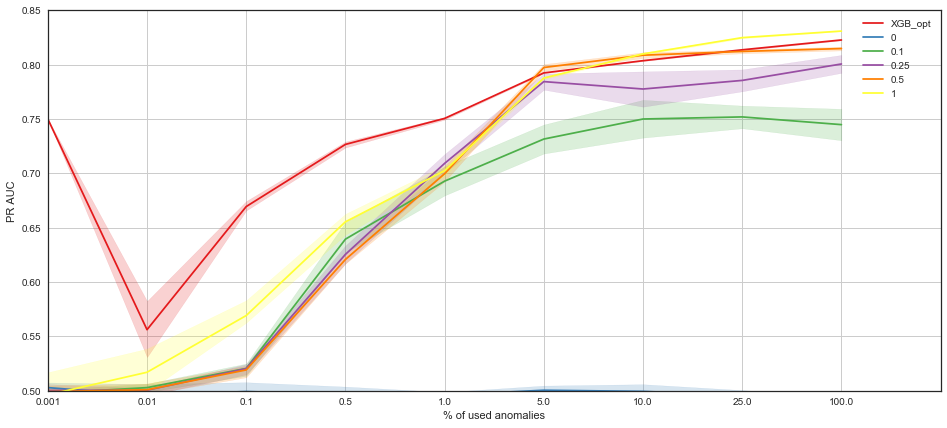

In [66]:
plot_for_comparison_with_percentile(pr_s_per, ylabel="PR AUC", y_lim=(0.5, 0.85), cmap=cmap, clf_names=clf_names)

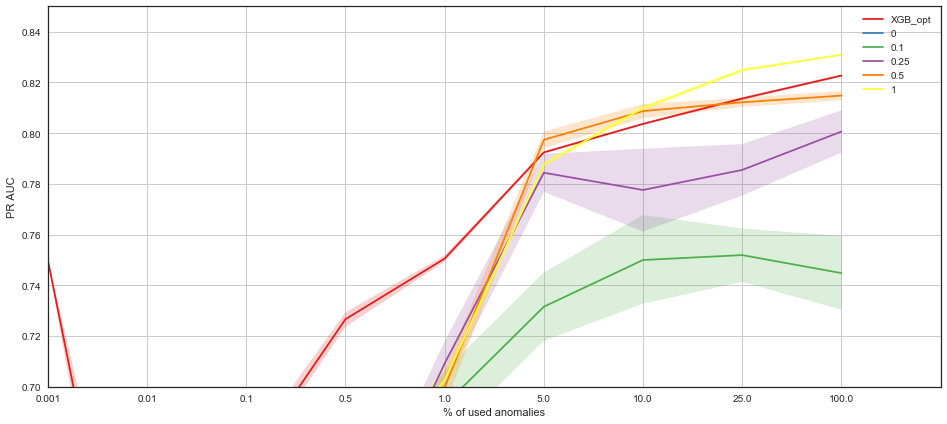

In [67]:
plot_for_comparison_with_percentile(pr_s_per, ylabel="PR AUC", y_lim=(0.7, 0.85), cmap=cmap, clf_names=clf_names)

#### ROC AUC

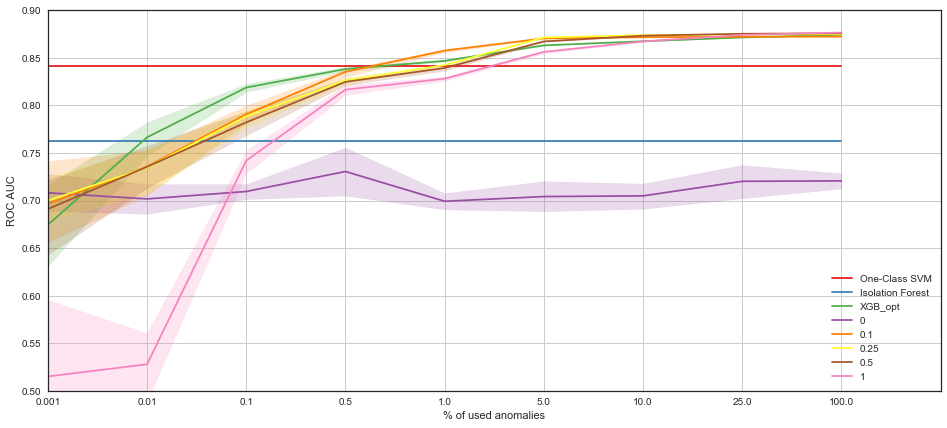

In [66]:
plot_for_comparison_with_percentile(roc_s_per, ylabel="ROC AUC", y_lim=(0.5, 0.9), cmap=cmap, clf_names=clf_names)

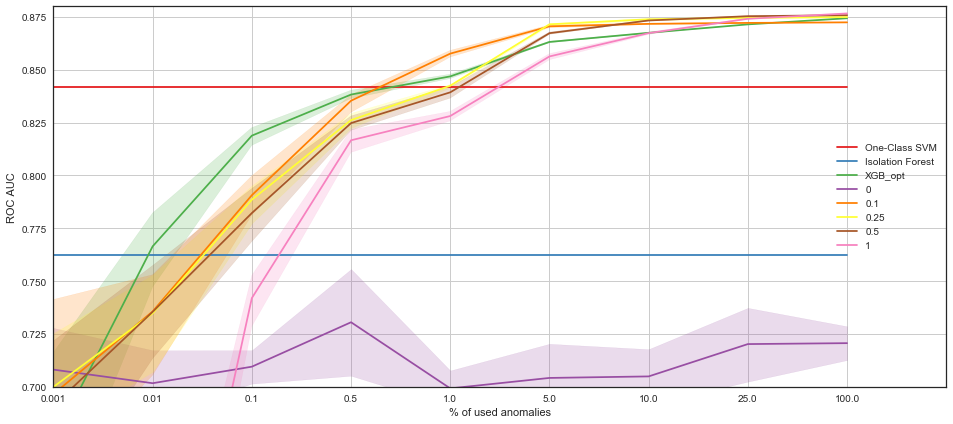

In [67]:
plot_for_comparison_with_percentile(roc_s_per, ylabel="ROC AUC", y_lim=(0.7, 0.88), cmap=cmap, clf_names=clf_names)

#### Precision at recall

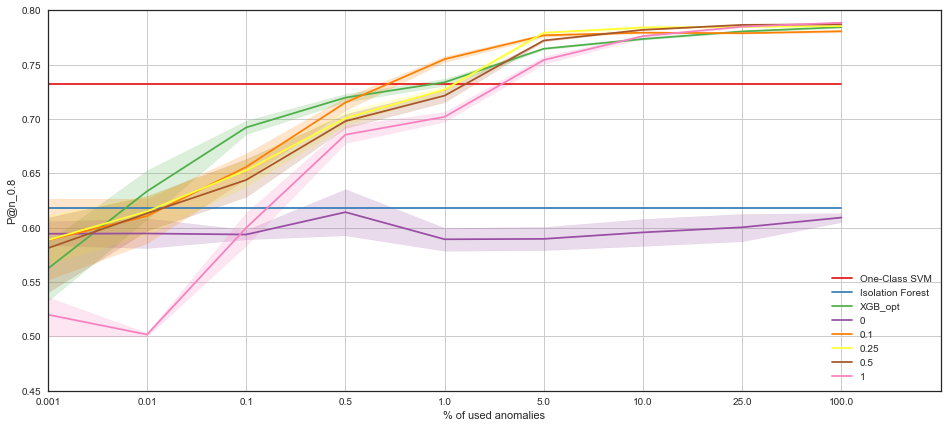

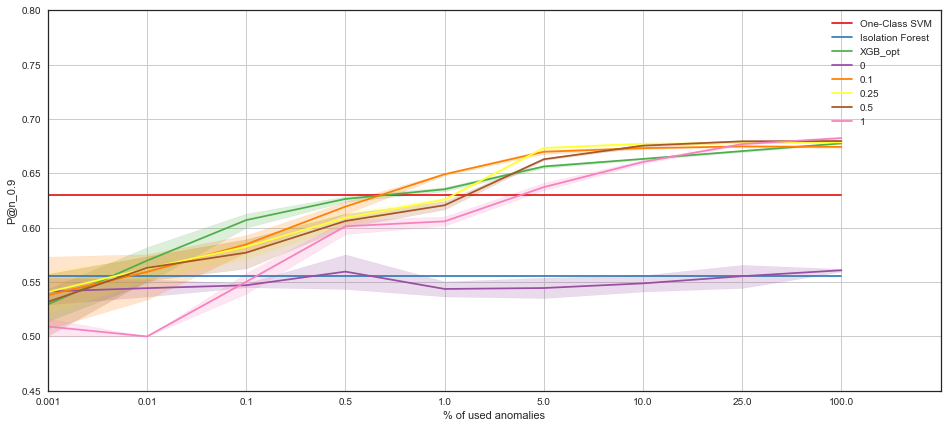

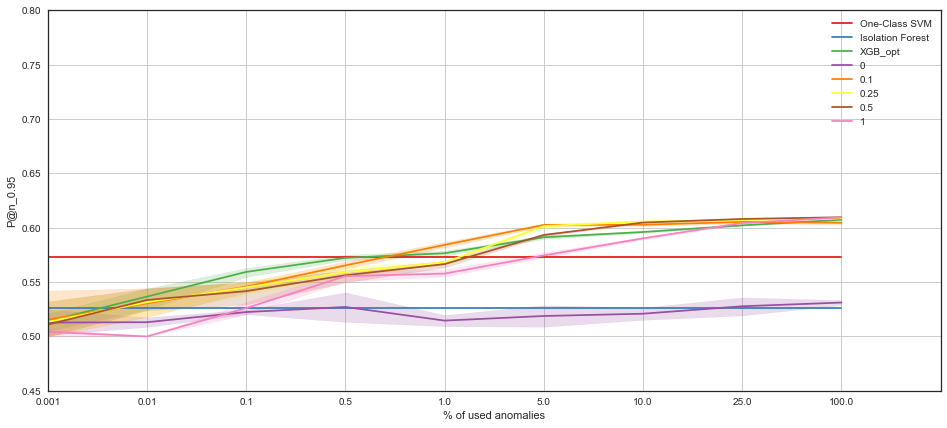

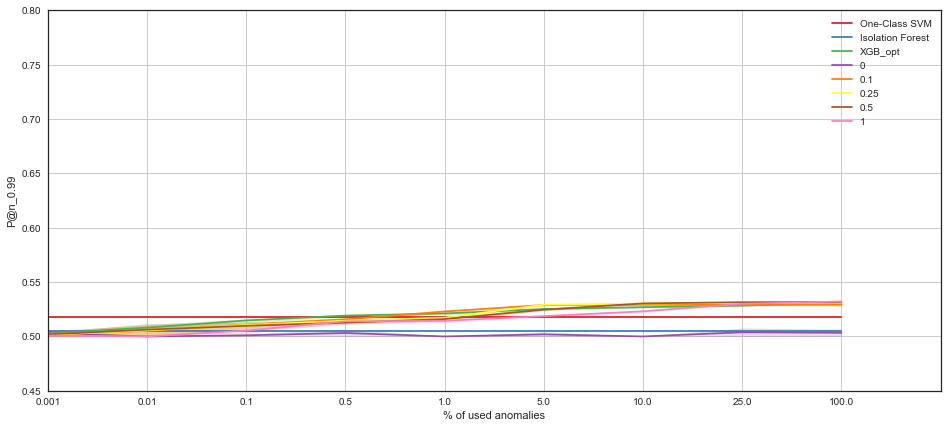

In [68]:
for key in p_at_r_s.keys():
    plot_for_comparison_with_percentile(p_at_r_s_per[key], ylabel="P@n_" + str(key), y_lim=(0.45, 0.8),
                                        cmap=cmap, clf_names=clf_names)

## Отобразим на графике только лучшие

In [80]:
clf_names = [
    'One-Class SVM', 
    'Isolation Forest', 
    'XGB_opt',
#     '0', 
    '0.1', 
#     '0.25', 
    '0.5', 
#     '1',
]

#### PR AUC

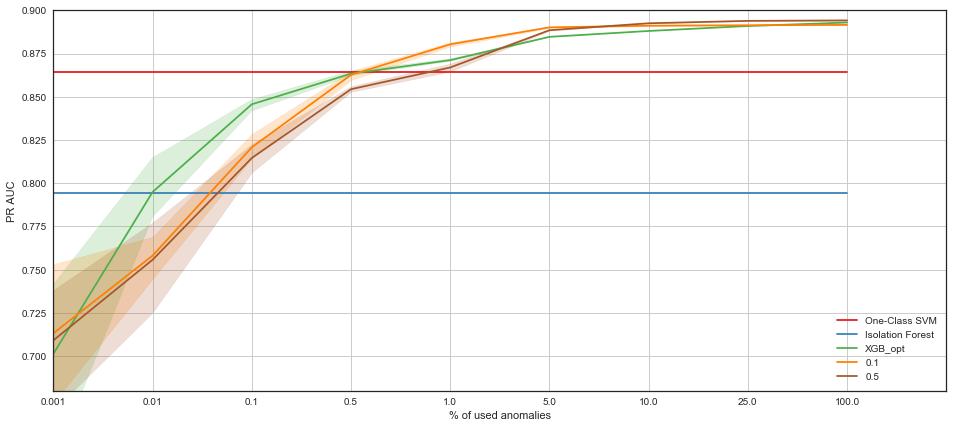

In [76]:
plot_for_comparison_with_percentile(pr_s_per, ylabel="PR AUC", y_lim=(0.68, 0.9), cmap=cmap, clf_names=clf_names)

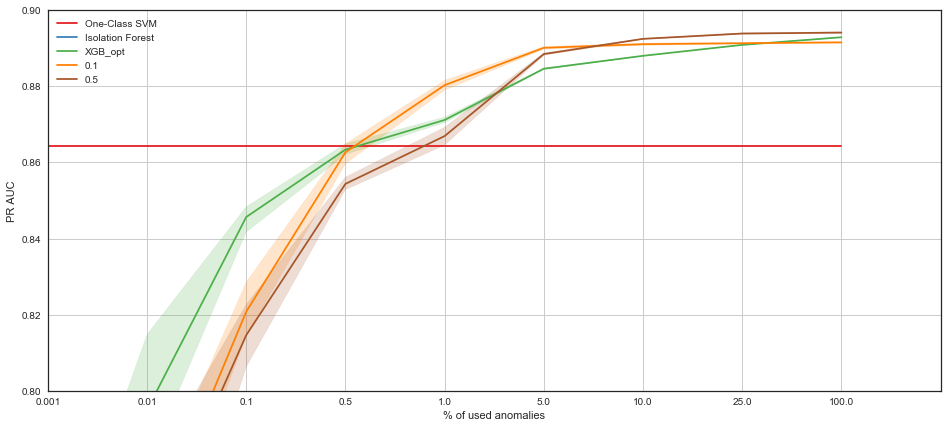

In [77]:
plot_for_comparison_with_percentile(pr_s_per, ylabel="PR AUC", y_lim=(0.8, 0.9), cmap=cmap, clf_names=clf_names)

#### ROC AUC

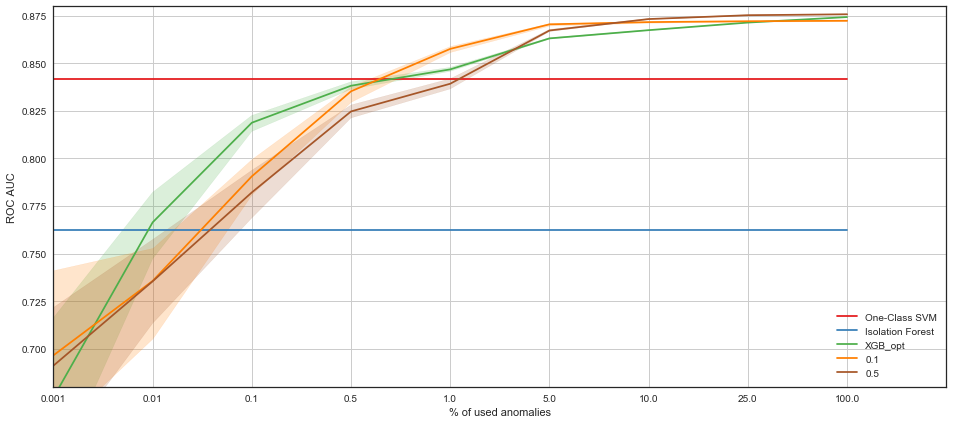

In [78]:
plot_for_comparison_with_percentile(roc_s_per, ylabel="ROC AUC", y_lim=(0.68, 0.88), cmap=cmap, clf_names=clf_names)

#### Precision at recall

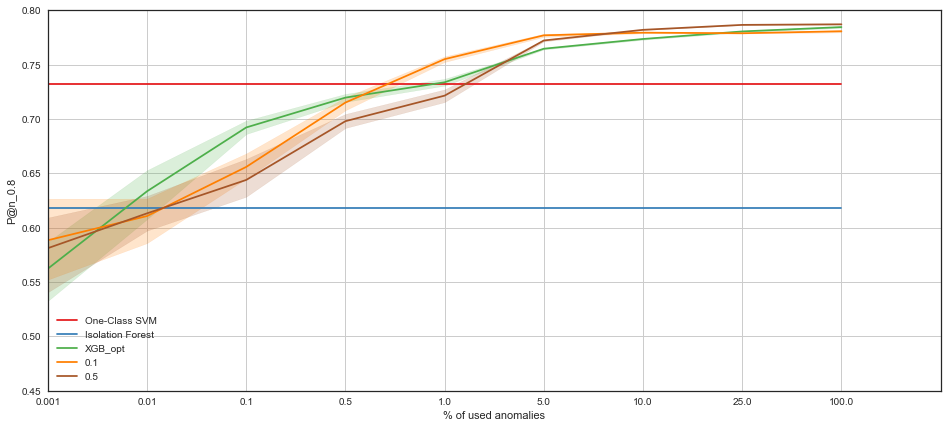

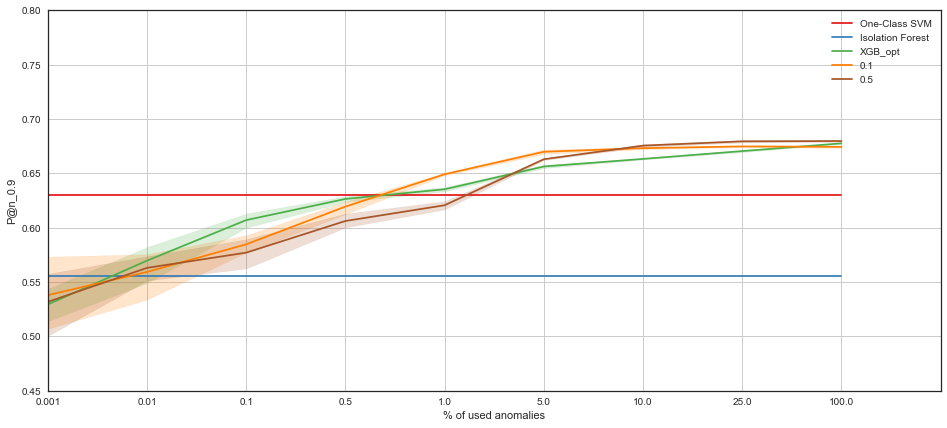

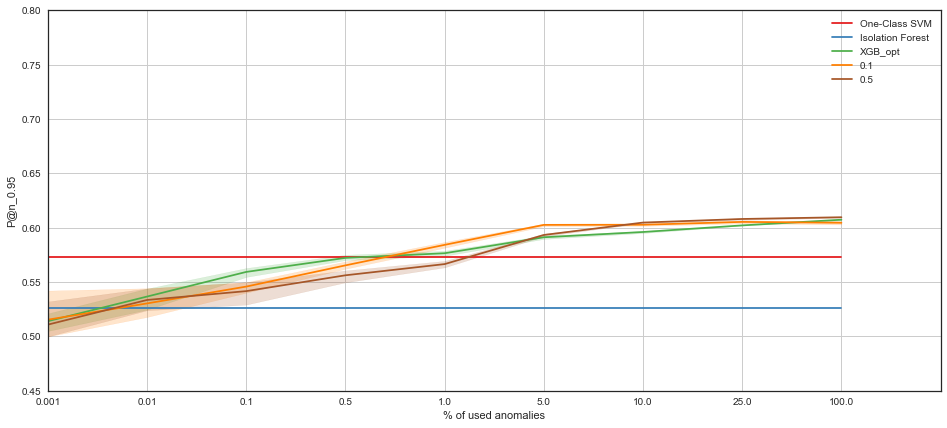

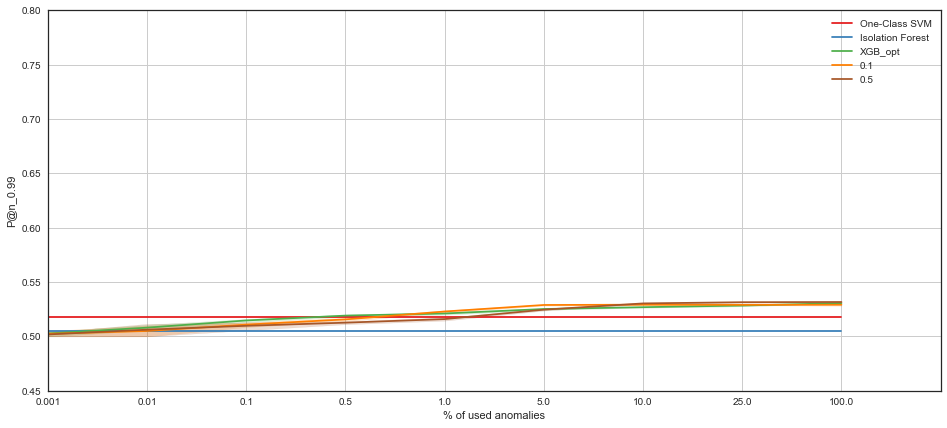

In [79]:
for key in p_at_r_s.keys():
    plot_for_comparison_with_percentile(p_at_r_s_per[key], ylabel="P@n_" + str(key), y_lim=(0.45, 0.8),
                                        cmap=cmap, clf_names=clf_names)